# 推理中常见并行策略原理


演示常见的并行策略原理


相关文章：[大模型推理并行策略(DP/TP/PP/SP/EP)原理简介](https://zhuanlan.zhihu.com/p/2003423046342554380)

Author: kaiyuan

Email: kyxie@zju.edu.cn

## 1 DP(Data Parellel)策略

思路：

场景1：一个模型副本，我们用一个线程来运行这个模型，然后有4个数据任务，我们用一个线程池（4个线程）来同时发送数据给这个模型，但是模型处理是串行的，所以我们可以在模型内部加锁，使得同时只能有一个线程（即一个数据）被处理。

场景2：四个模型副本，每个模型副本在一个线程中，然后有4个数据，我们同样用4个线程来发送数据，但是每个数据发送给不同的模型副本，这样就能并行处理。


In [ ]:
import threading
import time
from queue import Queue
import concurrent.futures
from typing import List
import random

class FakeModel:
    def __init__(self, model_id: int):
        self.model_id = model_id
        self.lock = threading.Lock()

    def process(self, data: str) -> str:
        """模拟模型处理数据的过程"""
        # 模拟处理时间
        processing_time = random.uniform(0.1, 0.5)  # 随机处理时间
        time.sleep(processing_time)

        # 打印处理信息
        with self.lock:
            result = f"模型副本{self.model_id} 接收数据: '{data}', 已处理 (耗时: {processing_time:.3f}s)"
            print(result)

        return result

def single_model_scenario(data_list: List[str]):
    """场景1: 单个模型副本处理所有数据"""
    print("\n" + "="*60)
    print("场景1: 单个模型副本处理4条数据")
    print("="*60)

    model = FakeModel(1)

    start_time = time.time()

    # 串行处理
    results = []
    for data in data_list:
        results.append(model.process(data))

    end_time = time.time()
    print(f"\n总耗时: {end_time - start_time:.3f}秒")
    return results, end_time - start_time

def multi_model_scenario(data_list: List[str], num_models: int = 4):
    """场景2: 多个模型副本并行处理数据"""
    print("\n" + "="*60)
    print(f"场景2: {num_models}个模型副本并行处理4条数据")
    print("="*60)

    # 创建多个模型副本
    models = [FakeModel(i+1) for i in range(num_models)]

    start_time = time.time()

    # 使用线程池并行处理
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_models) as executor:
        # 为每个数据分配一个模型副本
        future_to_data = {}
        for i, data in enumerate(data_list):
            model_idx = i % num_models  # 简单的数据分配策略
            future = executor.submit(models[model_idx].process, data)
            future_to_data[future] = data

        # 收集结果
        for future in concurrent.futures.as_completed(future_to_data):
            results.append(future.result())

    end_time = time.time()
    print(f"\n总耗时: {end_time - start_time:.3f}秒")
    return results, end_time - start_time

def data_parallel_simulation():
    """主模拟函数"""
    print("数据并行(DP)策略模拟演示")
    print("-" * 60)

    # 模拟4条数据
    data_list = [
        "数据1: 图像分类任务",
        "数据2: 自然语言处理",
        "数据3: 语音识别样本",
        "数据4: 视频分析帧"
    ]

    print("待处理数据:")
    for i, data in enumerate(data_list, 1):
        print(f"  数据{i}: {data}")

    # 场景1: 单个模型副本
    print("\n" + "="*60)
    print("开始模拟: 单个模型副本 vs 多个模型副本")
    print("="*60)

    # 重置随机种子以确保公平比较
    random.seed(42)
    results1, time1 = single_model_scenario(data_list.copy())

    # 场景2: 多个模型副本
    random.seed(42)  # 重置随机种子
    results2, time2 = multi_model_scenario(data_list.copy(), num_models=4)

    # 性能对比
    print("\n" + "="*60)
    print("性能对比总结")
    print("="*60)
    print(f"单个模型副本总耗时: {time1:.3f}秒")
    print(f"4个模型副本总耗时:  {time2:.3f}秒")
    print(f"加速比: {time1/time2:.2f}x")

    if time1 > time2:
        print(f"性能提升: {(time1 - time2)/time1*100:.1f}%")
    else:
        print("注意: 由于线程开销，加速效果可能不明显")


if __name__ == "__main__":
    data_parallel_simulation()



数据并行(DP)策略模拟演示
------------------------------------------------------------
待处理数据:
  数据1: 数据1: 图像分类任务
  数据2: 数据2: 自然语言处理
  数据3: 数据3: 语音识别样本
  数据4: 数据4: 视频分析帧

开始模拟: 单个模型副本 vs 多个模型副本

场景1: 单个模型副本处理4条数据
模型副本1 接收数据: '数据1: 图像分类任务', 已处理 (耗时: 0.356s)
模型副本1 接收数据: '数据2: 自然语言处理', 已处理 (耗时: 0.110s)
模型副本1 接收数据: '数据3: 语音识别样本', 已处理 (耗时: 0.210s)
模型副本1 接收数据: '数据4: 视频分析帧', 已处理 (耗时: 0.189s)

总耗时: 0.867秒

场景2: 4个模型副本并行处理4条数据
模型副本2 接收数据: '数据2: 自然语言处理', 已处理 (耗时: 0.110s)
模型副本4 接收数据: '数据4: 视频分析帧', 已处理 (耗时: 0.189s)
模型副本3 接收数据: '数据3: 语音识别样本', 已处理 (耗时: 0.210s)
模型副本1 接收数据: '数据1: 图像分类任务', 已处理 (耗时: 0.356s)

总耗时: 0.360秒

性能对比总结
单个模型副本总耗时: 0.867秒
4个模型副本总耗时:  0.360秒
加速比: 2.41x
性能提升: 58.5%


## 2 TP(Tensor Parallel)策略

### 2.1 矩阵的列切(column split)计算原理


矩阵分块计算结果进行拼接后，与原计算得到的结果相同。 TP和SP并行都用到了这个结论。

相关文章介绍：[LLM推理并行优化的必备知识](https://zhuanlan.zhihu.com/p/1937449564509545940)


In [ ]:
import numpy as np
# 1. 定义整数输入矩阵 (M, N) 和 (N, K)
M, N, K = 3, 4, 6
A = np.random.randint(0, 10, size=(M, N))  # 随机整数矩阵 [0, 10)
B = np.random.randint(0, 10, size=(N, K))
print("A:\n", A, "\nshape:", A.shape)
print("\nB:\n", B, "\nshape:", B.shape)

# 2. 对 B 按列切分（均分）
num_splits = 3  # 切分块数
B_splits = np.split(B, num_splits, axis=1)  # 沿列切分
print("\nB 分块结果:")
for i, B_i in enumerate(B_splits):
    print(f"B_{i}:\n", B_i, "\nshape:", B_i.shape)

# 3. 模拟并行计算：每个进程计算 A @ B_i
local_results = [A @ B_i for B_i in B_splits]
print("\n局部乘积结果:")
for i, C_i in enumerate(local_results):
    print(f"C_{i} (A @ B_{i}):\n", C_i, "\nshape:", C_i.shape)

# 4. 模拟 allgather：拼接所有局部结果
C_final = np.concatenate(local_results, axis=1)
print("\n合并后的 C_final:\n", C_final, "\nshape:", C_final.shape)

# 5. 验证结果与直接乘法的等价性
C_ground_truth = A @ B
print("\n标准乘法结果 (A @ B):\n", C_ground_truth)
print("\n验证一致性:", np.array_equal(C_final, C_ground_truth))


A:
 [[0 9 5 4]
 [2 1 5 2]
 [4 6 5 3]] 
shape: (3, 4)

B:
 [[8 8 8 0 4 8]
 [7 6 1 0 1 6]
 [4 3 4 4 9 1]
 [7 9 3 4 0 5]] 
shape: (4, 6)

B 分块结果:
B_0:
 [[8 8]
 [7 6]
 [4 3]
 [7 9]] 
shape: (4, 2)
B_1:
 [[8 0]
 [1 0]
 [4 4]
 [3 4]] 
shape: (4, 2)
B_2:
 [[4 8]
 [1 6]
 [9 1]
 [0 5]] 
shape: (4, 2)

局部乘积结果:
C_0 (A @ B_0):
 [[111 105]
 [ 57  55]
 [115 110]] 
shape: (3, 2)
C_1 (A @ B_1):
 [[41 36]
 [43 28]
 [67 32]] 
shape: (3, 2)
C_2 (A @ B_2):
 [[54 79]
 [54 37]
 [67 88]] 
shape: (3, 2)

合并后的 C_final:
 [[111 105  41  36  54  79]
 [ 57  55  43  28  54  37]
 [115 110  67  32  67  88]] 
shape: (3, 6)

标准乘法结果 (A @ B):
 [[111 105  41  36  54  79]
 [ 57  55  43  28  54  37]
 [115 110  67  32  67  88]]

验证一致性: True


### 2.2 TP过程演示

展示张量并行如何通过拆分大矩阵运算到多个计算单元来提高效率。

问题建模：

选择大矩阵（如1024×1024）模拟真实计算场景。将输入矩阵按列分块（column-wise/column-split），计算分配：每个线程处理矩阵A与B的一个列块的乘积。最后，将所有线程的计算结果拼接成完整输出矩阵。

对比机制:
- 基准测试：使用标准numpy矩阵乘法作为性能基准
- 并行实现：使用多线程模拟多设备并行计算
- 结果验证：确保并行计算与串行计算数值结果一致

性能对比：对比元计算与TP的速度差异

注意：机器不同计算速度不一样，性能对比数据仅供参考。

张量并行(TP)策略演示
模拟矩阵乘法的张量并行计算

生成2048×2048随机矩阵...

1. 标准numpy矩阵乘法 (基准):
   计算完成，耗时: 0.715秒

2. 张量并行矩阵乘法:

张量并行矩阵乘法 (使用2个工作线程)
矩阵A形状: (2048, 2048), 矩阵B形状: (2048, 2048)
  分配任务给工作线程1: 处理B的列0:1024
  分配任务给工作线程2: 处理B的列1024:2048

开始并行计算...
  工作线程1: 计算完成，耗时 0.433秒
  工作线程2: 计算完成，耗时 0.830秒

所有工作线程完成，总耗时: 0.841秒

3. 验证计算结果:

结果验证:
  最大绝对误差: 1.068115e-04
  最大相对误差: 5.074625e-02
计算结果存在显著差异

性能对比
标准numpy矩阵乘法耗时: 0.715秒
张量并行(2线程)矩阵乘法耗时: 0.841秒
注意: 由于Python GIL限制和线程开销，多线程可能不会加速CPU上的矩阵运算

不同矩阵大小下的性能分析

测试矩阵大小: 256×256

张量并行矩阵乘法 (使用2个工作线程)
矩阵A形状: (256, 256), 矩阵B形状: (256, 256)
  分配任务给工作线程1: 处理B的列0:128
  分配任务给工作线程2: 处理B的列128:256

开始并行计算...
  工作线程1: 计算完成，耗时 0.007秒
  工作线程2: 计算完成，耗时 0.005秒

所有工作线程完成，总耗时: 0.010秒
  标准numpy: 0.001秒
  张量并行: 0.010秒

测试矩阵大小: 512×512

张量并行矩阵乘法 (使用2个工作线程)
矩阵A形状: (512, 512), 矩阵B形状: (512, 512)
  分配任务给工作线程1: 处理B的列0:256
  分配任务给工作线程2: 处理B的列256:512

开始并行计算...
  工作线程1: 计算完成，耗时 0.008秒
  工作线程2: 计算完成，耗时 0.013秒

所有工作线程完成，总耗时: 0.019秒
  标准numpy: 0.011秒
  张量并行: 0.019秒

测试矩阵大小: 1024×1024

张量并行矩阵乘法 (使用2

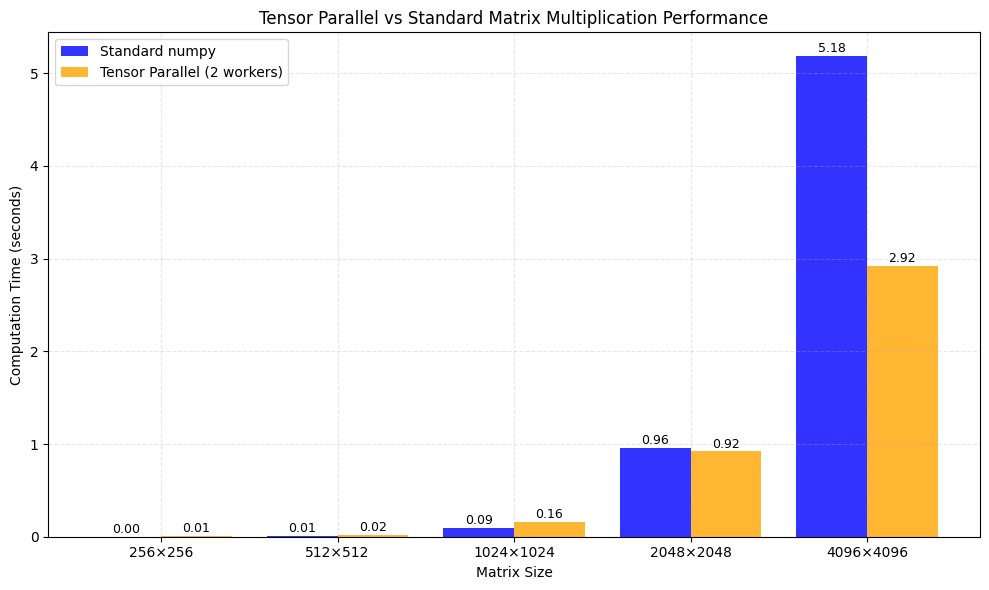


加速比分析:
  256×256矩阵: 加速比 = 0.07倍
  512×512矩阵: 加速比 = 0.59倍
  1024×1024矩阵: 加速比 = 0.56倍
  2048×2048矩阵: 加速比 = 1.04倍
  4096×4096矩阵: 加速比 = 1.77倍


In [ ]:
import numpy as np
import threading
import time
from typing import Tuple, List
import matplotlib.pyplot as plt

class TensorParallelSimulator:
    def __init__(self, matrix_size: int = 1024):
        """
        初始化张量并行模拟器

        Args:
            matrix_size: 矩阵大小 (n×n)
        """
        self.matrix_size = matrix_size
        self.numpy_runtime = None
        self.tp_runtime = None

    def generate_matrices(self) -> Tuple[np.ndarray, np.ndarray]:
        """生成随机矩阵用于乘法"""
        np.random.seed(42)  # 设置随机种子以保证可重复性
        A = np.random.randn(self.matrix_size, self.matrix_size).astype(np.float32)
        B = np.random.randn(self.matrix_size, self.matrix_size).astype(np.float32)
        return A, B

    def numpy_matmul(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        """使用numpy的标准矩阵乘法（基准）"""
        start_time = time.time()
        C = np.dot(A, B)
        end_time = time.time()
        self.numpy_runtime = end_time - start_time
        return C

    def tp_matmul_worker(self, A_part: np.ndarray, B_part: np.ndarray,
                         result_part: np.ndarray, worker_id: int):
        """张量并行工作线程：计算部分矩阵乘法"""
        start_time = time.time()
        # 计算部分结果
        partial_result = np.dot(A_part, B_part)

        # 将结果存入共享数组的相应部分
        result_part[:] = partial_result

        end_time = time.time()
        print(f"  工作线程{worker_id}: 计算完成，耗时 {end_time - start_time:.3f}秒")

    def tensor_parallel_matmul(self, A: np.ndarray, B: np.ndarray,
                               num_workers: int = 2) -> np.ndarray:
        """
        张量并行矩阵乘法

        策略：将矩阵B按列分块，每个线程计算A与B的一个列块的乘积
        最后将结果按列拼接
        """
        print(f"\n张量并行矩阵乘法 (使用{num_workers}个工作线程)")
        print(f"矩阵A形状: {A.shape}, 矩阵B形状: {B.shape}")

        # 计算每个工作线程处理的列数
        n_cols = B.shape[1]
        cols_per_worker = n_cols // num_workers

        # 初始化结果矩阵
        C_tp = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)

        threads = []
        start_time = time.time()

        # 创建并启动工作线程
        for i in range(num_workers):
            # 计算当前线程处理的列范围
            start_col = i * cols_per_worker
            # 最后一个线程处理剩余的所有列
            end_col = start_col + cols_per_worker if i < num_workers - 1 else n_cols

            # 获取B的对应列块
            B_part = B[:, start_col:end_col]

            # 获取结果矩阵的对应部分
            C_part = C_tp[:, start_col:end_col]

            # 创建工作线程
            thread = threading.Thread(
                target=self.tp_matmul_worker,
                args=(A, B_part, C_part, i+1)
            )
            threads.append(thread)

            print(f"  分配任务给工作线程{i+1}: 处理B的列{start_col}:{end_col}")

        # 启动所有线程
        print("\n开始并行计算...")
        for thread in threads:
            thread.start()

        # 等待所有线程完成
        for thread in threads:
            thread.join()

        end_time = time.time()
        self.tp_runtime = end_time - start_time

        print(f"\n所有工作线程完成，总耗时: {self.tp_runtime:.3f}秒")
        return C_tp

    def validate_result(self, C_numpy: np.ndarray, C_tp: np.ndarray) -> bool:
        """验证两种方法的结果是否一致（在数值误差范围内）"""
        # 计算最大绝对误差和相对误差
        abs_error = np.max(np.abs(C_numpy - C_tp))
        rel_error = np.max(np.abs(C_numpy - C_tp) / (np.abs(C_numpy) + 1e-10))

        print(f"\n结果验证:")
        print(f"  最大绝对误差: {abs_error:.6e}")
        print(f"  最大相对误差: {rel_error:.6e}")

        # 检查是否在可接受的误差范围内
        tolerance = 1e-5
        is_valid = abs_error < tolerance

        if is_valid:
            print("张量并行计算结果与标准numpy计算结果一致！")
        else:
            print("计算结果存在显著差异")

        return is_valid

    def compare_performance(self):
        """比较性能并打印结果"""
        print("\n" + "="*60)
        print("性能对比")
        print("="*60)
        print(f"标准numpy矩阵乘法耗时: {self.numpy_runtime:.3f}秒")
        print(f"张量并行(2线程)矩阵乘法耗时: {self.tp_runtime:.3f}秒")

        if self.numpy_runtime > self.tp_runtime:
            speedup = self.numpy_runtime / self.tp_runtime
            improvement = (self.numpy_runtime - self.tp_runtime) / self.numpy_runtime * 100
            print(f"加速比: {speedup:.2f}倍")
            print(f"性能提升: {improvement:.1f}%")
        else:
            print("注意: 由于Python GIL限制和线程开销，多线程可能不会加速CPU上的矩阵运算")

def plot_comparison():
    """绘制不同矩阵大小下的性能对比"""
    print("\n" + "="*60)
    print("不同矩阵大小下的性能分析")
    print("="*60)

    sizes = [256, 512, 1024, 2048, 4096]
    numpy_times = []
    tp_times = []

    for size in sizes:
        print(f"\n测试矩阵大小: {size}×{size}")
        simulator = TensorParallelSimulator(matrix_size=size)
        A, B = simulator.generate_matrices()

        # 标准numpy
        start = time.time()
        _ = np.dot(A, B)
        numpy_time = time.time() - start
        numpy_times.append(numpy_time)

        # 张量并行（2线程）
        C_tp = simulator.tensor_parallel_matmul(A, B, num_workers=2)
        tp_times.append(simulator.tp_runtime)

        print(f"  标准numpy: {numpy_time:.3f}秒")
        print(f"  张量并行: {simulator.tp_runtime:.3f}秒")

    # 绘制图表
    plt.figure(figsize=(10, 6))
    x = range(len(sizes))

    plt.bar([i - 0.2 for i in x], numpy_times, width=0.4, label='Standard numpy', alpha=0.8, color='blue')
    plt.bar([i + 0.2 for i in x], tp_times, width=0.4, label='Tensor Parallel (2 workers)', alpha=0.8, color='orange')

    plt.xlabel('Matrix Size')
    plt.ylabel('Computation Time (seconds)')
    plt.title('Tensor Parallel vs Standard Matrix Multiplication Performance')
    plt.xticks(x, [f'{size}×{size}' for size in sizes])
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')

    # 在柱状图上添加数值标签
    for i, v in enumerate(numpy_times):
        plt.text(i - 0.2, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(tp_times):
        plt.text(i + 0.2, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # 计算加速比
    print("\n加速比分析:")
    for i, size in enumerate(sizes):
        speedup = numpy_times[i] / tp_times[i] if tp_times[i] > 0 else 0
        print(f"  {size}×{size}矩阵: 加速比 = {speedup:.2f}倍")

def main():
    """主函数"""
    print("="*60)
    print("张量并行(TP)策略演示")
    print("模拟矩阵乘法的张量并行计算")
    print("="*60)

    # 创建模拟器
    matrix_size = 2048  # 可以调整矩阵大小
    simulator = TensorParallelSimulator(matrix_size=matrix_size)

    # 生成测试矩阵
    print(f"\n生成{matrix_size}×{matrix_size}随机矩阵...")
    A, B = simulator.generate_matrices()

    # 1. 标准numpy矩阵乘法（基准）
    print("\n1. 标准numpy矩阵乘法 (基准):")
    C_numpy = simulator.numpy_matmul(A, B)
    print(f"   计算完成，耗时: {simulator.numpy_runtime:.3f}秒")

    # 2. 张量并行矩阵乘法
    print("\n2. 张量并行矩阵乘法:")
    C_tp = simulator.tensor_parallel_matmul(A, B, num_workers=2)

    # 3. 验证结果正确性
    print("\n3. 验证计算结果:")
    simulator.validate_result(C_numpy, C_tp)

    # 4. 性能对比
    simulator.compare_performance()

    # 5. 不同矩阵大小性能分析
    plot_comparison()


if __name__ == "__main__":
    main()

## 3 SP（Seqeunce Parallel）策略

使用线程模拟多设备，并且使用简单的全连接层。对比：

- 不切序列：整个序列数据通过一个完整的模型（多个层）进行计算。

- 切序列（序列并行）：将序列分成多个部分，每个部分通过一个设备（用线程模拟）上的子模型计算，然后将结果合并。

步骤：

* 定义模型
* 生成输入数据
* 运行不切序列版本
* 运行切序列版本（序列并行）
* 比较结果和时间

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import threading
import numpy as np
import copy

class SimpleFeedForwardBlock(nn.Module):
    def __init__(self, d_model: int = 512, hidden_dim: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
        )

        self.norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ffn_output = self.ffn(x)
        x = x + ffn_output
        x = self.norm(x)

        return x

class SequenceParallelSimulator:
    def __init__(self, seq_len: int = 1024, d_model: int = 512):
        """
        初始化序列并行模拟器

        Args:
            seq_len: 序列长度
            d_model: 模型维度
        """
        self.seq_len = seq_len
        self.d_model = d_model

        # 固定随机种子
        torch.manual_seed(42)
        np.random.seed(42)

        # 创建主模型
        self.model = SimpleFeedForwardBlock(d_model)

        # 生成测试数据
        self.input_data = None
        self.generate_data()

        # 时间记录
        self.serial_time = None
        self.parallel_time = None

    def generate_data(self):
        """生成测试数据"""
        # 固定随机种子生成输入序列
        self.input_data = torch.randn(1, self.seq_len, self.d_model)
        print(f"生成测试数据: batch_size=1, seq_len={self.seq_len}, d_model={self.d_model}")
        print(f"输入数据范围: [{self.input_data.min():.4f}, {self.input_data.max():.4f}]")

    def serial_processing(self) -> torch.Tensor:
        """串行处理：整个序列一次性处理"""
        print(f"\n串行处理 - 完整序列 ({self.seq_len} tokens)")

        # 确保模型在评估模式
        self.model.eval()

        # 预热
        with torch.no_grad():
            _ = self.model(self.input_data[:, :10, :])

        # 正式计时
        start_time = time.time()

        # 完整序列一次性处理
        with torch.no_grad():
            output = self.model(self.input_data)

        end_time = time.time()
        self.serial_time = end_time - start_time

        print(f"串行处理完成，耗时: {self.serial_time:.4f}秒")
        return output

    def parallel_worker(self,
                       model: nn.Module,
                       input_chunk: torch.Tensor,
                       output_chunk: List,
                       worker_id: int):
        """并行工作线程：处理序列的一个片段"""
        start_time = time.time()

        # 处理序列片段
        with torch.no_grad():
            chunk_output = model(input_chunk)

        end_time = time.time()

        # 存储结果
        output_chunk[worker_id] = chunk_output

        print(f"  工作线程{worker_id+1}: 处理{input_chunk.shape[1]}个token，耗时: {end_time - start_time:.4f}秒")

    def sequence_parallel_processing(self, num_chunks: int = 2) -> torch.Tensor:
        """序列并行处理：将序列切分成多个片段并行处理"""
        print(f"\n序列并行处理 - 将序列分成{num_chunks}个片段")

        # 计算每个片段的大小
        chunk_size = self.seq_len // num_chunks

        print(f"每个片段大小: {chunk_size} tokens")

        # 创建多个模型副本，确保使用相同的权重
        models = []
        for i in range(num_chunks):
            # 深拷贝模型，确保权重相同
            model_copy = copy.deepcopy(self.model)
            model_copy.eval()  # 设置为评估模式
            models.append(model_copy)

            # 验证权重是否相同
            if i > 0:
                params1 = list(models[0].parameters())
                params2 = list(model_copy.parameters())
                for p1, p2 in zip(params1, params2):
                    if not torch.allclose(p1, p2):
                        print(f"警告: 模型{i}的权重与模型0不同！")

        # 切分输入序列
        input_chunks = []
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size if i < num_chunks - 1 else self.seq_len
            chunk = self.input_data[:, start_idx:end_idx, :]
            input_chunks.append(chunk)
            print(f"  片段{i+1}数据范围: [{chunk.min():.4f}, {chunk.max():.4f}]")

        # 准备存储结果的列表
        output_chunks = [None] * num_chunks

        # 创建并启动线程
        threads = []
        start_time = time.time()

        for i in range(num_chunks):
            thread = threading.Thread(
                target=self.parallel_worker,
                args=(models[i], input_chunks[i], output_chunks, i)
            )
            threads.append(thread)

            print(f"  分配任务给工作线程{i+1}: 处理token范围 [{i*chunk_size}:{(i+1)*chunk_size if i < num_chunks-1 else self.seq_len}]")

        print("\n开始并行处理...")
        for thread in threads:
            thread.start()

        # 等待所有线程完成
        for thread in threads:
            thread.join()

        # 合并结果
        print("合并结果...")
        parallel_output = torch.cat(output_chunks, dim=1)

        end_time = time.time()
        self.parallel_time = end_time - start_time

        print(f"序列并行处理完成，总耗时: {self.parallel_time:.4f}秒")
        return parallel_output

    def validate_result(self, serial_output: torch.Tensor, parallel_output: torch.Tensor) -> bool:
        """验证两种方法的结果是否一致"""
        print("\n结果验证:")

        # 打印输出范围以供参考
        print(f"  串行输出范围: [{serial_output.min():.4f}, {serial_output.max():.4f}]")
        print(f"  并行输出范围: [{parallel_output.min():.4f}, {parallel_output.max():.4f}]")

        # 检查形状是否相同
        if serial_output.shape != parallel_output.shape:
            print(f"  形状不匹配: 串行{serial_output.shape} vs 并行{parallel_output.shape}")
            return False

        # 计算差异
        abs_diff = torch.max(torch.abs(serial_output - parallel_output)).item()
        rel_diff = torch.max(torch.abs(serial_output - parallel_output) / (torch.abs(serial_output) + 1e-10)).item()

        print(f"  最大绝对差异: {abs_diff:.6e}")
        print(f"  最大相对差异: {rel_diff:.6e}")

        # 检查是否在可接受的误差范围内（浮点数计算误差）
        tolerance = 1e-6
        is_valid = abs_diff < tolerance

        if is_valid:
            print("序列并行计算结果与串行计算结果一致！")
        else:
            print("计算结果存在显著差异")

        return is_valid

    def compare_performance(self):
        """比较性能并打印结果"""
        print("\n" + "="*60)
        print("性能对比")
        print("="*60)
        print(f"串行处理耗时: {self.serial_time:.4f}秒")
        print(f"序列并行(2线程)处理耗时: {self.parallel_time:.4f}秒")

        if self.serial_time and self.parallel_time:
            if self.serial_time > self.parallel_time:
                speedup = self.serial_time / self.parallel_time
                improvement = (self.serial_time - self.parallel_time) / self.serial_time * 100
                print(f"加速比: {speedup:.2f}倍")
                print(f"性能提升: {improvement:.1f}%")
            else:
                print("注意: 由于线程开销和小矩阵运算，多线程可能不会加速")

def main():
    """主函数"""
    print("="*60)
    print("序列并行(SP)策略演示")
    print("模拟逐位置操作的序列并行（如前馈网络）")
    print("="*60)

    # 创建模拟器
    seq_len = 2048  # 使用较长的序列
    d_model = 512
    simulator = SequenceParallelSimulator(seq_len=seq_len, d_model=d_model)

    # 1. 串行处理
    print("\n1. 串行处理 (基准):")
    serial_output = simulator.serial_processing()

    # 2. 序列并行处理
    print("\n2. 序列并行处理:")
    parallel_output = simulator.sequence_parallel_processing(num_chunks=2)

    # 3. 验证结果
    print("\n3. 验证计算结果:")
    is_valid = simulator.validate_result(serial_output, parallel_output)


    # 4. 性能对比
    simulator.compare_performance()


if __name__ == "__main__":
    main()

序列并行(SP)策略演示
模拟逐位置操作的序列并行（如前馈网络）
生成测试数据: batch_size=1, seq_len=2048, d_model=512
输入数据范围: [-4.5161, 4.5343]

1. 串行处理 (基准):

串行处理 - 完整序列 (2048 tokens)
串行处理完成，耗时: 0.1974秒

2. 序列并行处理:

序列并行处理 - 将序列分成2个片段
每个片段大小: 1024 tokens
  片段1数据范围: [-4.5161, 4.4615]
  片段2数据范围: [-4.4507, 4.5343]
  分配任务给工作线程1: 处理token范围 [0:1024]
  分配任务给工作线程2: 处理token范围 [1024:2048]

开始并行处理...
  工作线程2: 处理1024个token，耗时: 0.1608秒
  工作线程1: 处理1024个token，耗时: 0.1624秒
合并结果...
序列并行处理完成，总耗时: 0.1641秒

3. 验证计算结果:

结果验证:
  串行输出范围: [-4.4356, 4.6646]
  并行输出范围: [-4.4356, 4.6646]
  最大绝对差异: 0.000000e+00
  最大相对差异: 0.000000e+00
序列并行计算结果与串行计算结果一致！

性能对比
串行处理耗时: 0.1974秒
序列并行(2线程)处理耗时: 0.1641秒
加速比: 1.20倍
性能提升: 16.9%


## 4 PP（Pipeline Parallelism）策略

构建一个流水线并行的演示：假设模型有两层，我们将这两层分别放在两个线程（或设备）上。流水线并行中，数据被分成多个微批次（micro-batches），每个微批次依次通过模型的各个阶段（层）。在这个例子中，有两个阶段（两个线程），每个线程处理模型的一层。模拟：将一个批次的数据分成两个微批次，然后通过流水线的方式处理。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import threading
import numpy as np
from queue import Queue
from typing import Tuple, List

class SimpleNNLayer1(nn.Module):
    """第一层神经网络"""
    def __init__(self, input_dim: int = 512, hidden_dim: int = 1024):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = self.norm(x)
        x = F.relu(x)
        return x

class SimpleNNLayer2(nn.Module):
    """第二层神经网络"""
    def __init__(self, hidden_dim: int = 1024, output_dim: int = 512):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = self.norm(x)
        x = torch.tanh(x)
        return x

class PipelineParallelSimulator:
    def __init__(self, batch_size: int = 8, seq_len: int = 32, feature_dim: int = 512):
        """
        初始化流水线并行模拟器

        Args:
            batch_size: 批次大小
            seq_len: 序列长度
            feature_dim: 特征维度
        """
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.feature_dim = feature_dim

        # 固定随机种子
        torch.manual_seed(42)
        np.random.seed(42)

        # 创建完整模型
        self.full_model = nn.Sequential(
            SimpleNNLayer1(feature_dim, 1024),
            SimpleNNLayer2(1024, feature_dim)
        )

        # 创建分层的模型（用于流水线并行）
        self.layer1 = SimpleNNLayer1(feature_dim, 1024)
        self.layer2 = SimpleNNLayer2(1024, feature_dim)

        # 生成测试数据
        self.input_data = None
        self.generate_data()

        # 同步两个模型的权重
        self.sync_weights()

    def generate_data(self):
        """生成测试数据"""
        # 固定随机种子生成输入数据
        self.input_data = torch.randn(self.batch_size, self.seq_len, self.feature_dim)
        print(f"生成测试数据: batch_size={self.batch_size}, seq_len={self.seq_len}, feature_dim={self.feature_dim}")

    def sync_weights(self):
        """同步完整模型和分层模型的权重"""
        # 从完整模型中提取第一层权重
        self.layer1.load_state_dict({
            'linear.weight': self.full_model[0].linear.weight.data.clone(),
            'linear.bias': self.full_model[0].linear.bias.data.clone(),
            'norm.weight': self.full_model[0].norm.weight.data.clone(),
            'norm.bias': self.full_model[0].norm.bias.data.clone()
        })

        # 从完整模型中提取第二层权重
        self.layer2.load_state_dict({
            'linear.weight': self.full_model[1].linear.weight.data.clone(),
            'linear.bias': self.full_model[1].linear.bias.data.clone(),
            'norm.weight': self.full_model[1].norm.weight.data.clone(),
            'norm.bias': self.full_model[1].norm.bias.data.clone()
        })

        # 设置为评估模式
        self.full_model.eval()
        self.layer1.eval()
        self.layer2.eval()

    def sequential_processing(self) -> torch.Tensor:
        """顺序处理：整个模型一次性计算"""
        print(f"\n顺序处理 (基准):")
        print(f"  批次大小: {self.batch_size}, 一次性通过完整的两层模型")

        with torch.no_grad():
            output = self.full_model(self.input_data)

        print(f"  顺序处理完成")
        return output

    def pipeline_worker_stage1(self,
                              input_queue: Queue,
                              output_queue: Queue,
                              num_microbatches: int):
        """流水线工作线程 - 阶段1（第一层）"""
        print("  阶段1线程: 启动")

        for i in range(num_microbatches):
            # 从输入队列获取数据
            data = input_queue.get()
            if data is None:  # 结束信号
                break

            # 处理数据（第一层）
            with torch.no_grad():
                output = self.layer1(data)

            # 将结果放入输出队列（传递给阶段2）
            output_queue.put(output)

            print(f"    阶段1: 处理微批次{i+1}/{num_microbatches}完成")

        # 发送结束信号
        output_queue.put(None)
        print("  阶段1线程: 结束")

    def pipeline_worker_stage2(self,
                              input_queue: Queue,
                              output_queue: Queue,
                              num_microbatches: int):
        """流水线工作线程 - 阶段2（第二层）"""
        print("  阶段2线程: 启动")

        final_outputs = []

        for i in range(num_microbatches):
            # 从输入队列获取数据（来自阶段1）
            data = input_queue.get()
            if data is None:  # 结束信号
                break

            # 处理数据（第二层）
            with torch.no_grad():
                output = self.layer2(data)

            # 收集最终输出
            final_outputs.append(output)

            print(f"    阶段2: 处理微批次{i+1}/{num_microbatches}完成")

        # 合并所有微批次的输出
        if final_outputs:
            final_output = torch.cat(final_outputs, dim=0)
        else:
            final_output = torch.tensor([])

        # 将最终结果放入输出队列
        output_queue.put(final_output)

        print("  阶段2线程: 结束")

    def pipeline_parallel_processing(self, num_microbatches: int = 4) -> torch.Tensor:
        """流水线并行处理：将批次数据分成微批次，通过流水线处理"""
        print(f"\n流水线并行处理:")
        print(f"  将批次分成{num_microbatches}个微批次")
        print(f"  微批次大小: {self.batch_size // num_microbatches}")

        # 计算微批次大小
        microbatch_size = self.batch_size // num_microbatches

        # 创建队列用于线程间通信
        input_queue_stage1 = Queue()
        intermediate_queue = Queue()
        output_queue_stage2 = Queue()

        # 创建并启动阶段1线程
        stage1_thread = threading.Thread(
            target=self.pipeline_worker_stage1,
            args=(input_queue_stage1, intermediate_queue, num_microbatches)
        )

        # 创建并启动阶段2线程
        stage2_thread = threading.Thread(
            target=self.pipeline_worker_stage2,
            args=(intermediate_queue, output_queue_stage2, num_microbatches)
        )

        print("启动流水线...")
        stage1_thread.start()
        stage2_thread.start()

        # 主线程：将微批次数据送入阶段1
        for i in range(num_microbatches):
            # 获取当前微批次数据
            start_idx = i * microbatch_size
            end_idx = start_idx + microbatch_size
            microbatch = self.input_data[start_idx:end_idx]

            # 放入阶段1的输入队列
            input_queue_stage1.put(microbatch)

            print(f"  主线程: 发送微批次{i+1}/{num_microbatches}到阶段1")

        # 发送结束信号到阶段1
        input_queue_stage1.put(None)

        # 等待阶段2完成并获取最终结果
        pipeline_output = output_queue_stage2.get()

        # 等待所有线程结束
        stage1_thread.join()
        stage2_thread.join()

        print("流水线并行处理完成")
        return pipeline_output

    def validate_result(self, sequential_output: torch.Tensor, pipeline_output: torch.Tensor) -> bool:
        """验证两种方法的结果是否一致"""
        print("\n结果验证:")

        # 检查形状是否相同
        if sequential_output.shape != pipeline_output.shape:
            print(f"  形状不匹配: 顺序处理{sequential_output.shape} vs 流水线{pipeline_output.shape}")
            return False

        # 计算差异
        abs_diff = torch.max(torch.abs(sequential_output - pipeline_output)).item()
        rel_diff = torch.max(torch.abs(sequential_output - pipeline_output) / (torch.abs(sequential_output) + 1e-10)).item()

        print(f"  最大绝对差异: {abs_diff:.6e}")
        print(f"  最大相对差异: {rel_diff:.6e}")

        # 检查是否在可接受的误差范围内（浮点数计算误差）
        tolerance = 1e-6
        is_valid = abs_diff < tolerance

        if is_valid:
            print("流水线并行计算结果与顺序计算结果一致！")
        else:
            print("计算结果存在显著差异")

        return is_valid


def main():
    """主函数"""
    print("="*60)
    print("流水线并行(PP)策略演示")
    print("模拟两层模型的流水线并行处理")
    print("="*60)

    # 创建模拟器
    batch_size = 8
    seq_len = 32
    feature_dim = 512

    simulator = PipelineParallelSimulator(
        batch_size=batch_size,
        seq_len=seq_len,
        feature_dim=feature_dim
    )

    # 1. 顺序处理
    print("\n1. 顺序处理 (基准):")
    sequential_output = simulator.sequential_processing()

    # 2. 流水线并行处理
    print("\n2. 流水线并行处理:")
    pipeline_output = simulator.pipeline_parallel_processing(num_microbatches=4)

    # 3. 验证结果
    print("\n3. 验证计算结果:")
    simulator.validate_result(sequential_output, pipeline_output)




if __name__ == "__main__":
    main()

流水线并行(PP)策略演示
模拟两层模型的流水线并行处理
生成测试数据: batch_size=8, seq_len=32, feature_dim=512

1. 顺序处理 (基准):

顺序处理 (基准):
  批次大小: 8, 一次性通过完整的两层模型
  顺序处理完成

2. 流水线并行处理:

流水线并行处理:
  将批次分成4个微批次
  微批次大小: 2
启动流水线...
  阶段1线程: 启动
  阶段2线程: 启动
  主线程: 发送微批次1/4到阶段1
  主线程: 发送微批次2/4到阶段1
  主线程: 发送微批次3/4到阶段1
  主线程: 发送微批次4/4到阶段1
    阶段1: 处理微批次1/4完成
    阶段1: 处理微批次2/4完成
    阶段2: 处理微批次1/4完成
    阶段1: 处理微批次3/4完成
    阶段2: 处理微批次2/4完成
    阶段1: 处理微批次4/4完成
  阶段1线程: 结束
    阶段2: 处理微批次3/4完成
    阶段2: 处理微批次4/4完成
  阶段2线程: 结束
流水线并行处理完成

3. 验证计算结果:

结果验证:
  最大绝对差异: 0.000000e+00
  最大相对差异: 0.000000e+00
流水线并行计算结果与顺序计算结果一致！
